# INIT

In [3]:
import sys
sys.path.append('../../../deconv_py/')
sys.path.append('../../infras/cellMix/')
sys.path.append('../../infras/cytof_data/')
sys.path.append('../../infras/ctpnet/')
sys.path.append('../../infras/')
sys.path.append('../../infras/dashboards/')
sys.path.append('../../experiments/')
sys.path.append('../../experiments/pipeline/')
sys.path.append('../../preprocess/intra_variance/')
sys.path.append('../../models/cell_proportions/')
sys.path.append('../../measures/cell_proportions_measures/')
sys.path.append('../../preprocess/cell_specifics/')
sys.path.append('../../preprocess/data_sets/')


In [4]:
from data_factory import DataFactory
from global_utils import GlobalUtils
from cytof_cell_count_infra import CytofCellCountInfra
from cell_proportions_experiments import  CellProportionsExperiments
import exploration_cytof_plots as cytof_plots

from pp_entropy_based import PpEntropyBased
from pp_dep_de_based import  PpDepDeBased
from cell_proportions_measure import CellProportionsMeasure
from pp_clean_high_intra_var import PpCleanHighIntraVar
from pp_clean_irrelevant_proteins import PpCleanIrrelevantProteins
from pp_empty import PpEmpty
from pp_entropy_based_only_largest import PpEntropyBasedOnlyLargest
from aggregate_intra_variance import AggregateIntraVariance
from pipeline_deconv import PipelineDeconv
from deconv_py.preprocess.base import BasePreprocess as PP_base
from deconv_py.preprocess.cell_specific import CellSpecific as PP_proteins
from deconv_py.preprocess.cell_specifics.pp_svm_signature import PpSvmSignature
from deconv_py.preprocess.cell_specifics.pp_entropy_based_totel_sum import PpEntropyBasedTotelSum
from deconv_py.preprocess.cell_specifics.pp_floor_under_quantile import PpFloorUnderQuantile
from pick_data_set import PickDataSet
# from deconvolution_results_plots import DeconvolutionResultsPlots

from basic import BasicDeconv
from regression import RegressionDeconv
from generalized_estimating_equations import GeneralizedEstimatingEquations
from robust_linear_model import RobustLinearModel
from deconvolution_model import DeconvolutionModel


from pp_keep_specific_cells  import  PpKeepSpecificCells
from pp_agg_to_specific_cells import PpAggToSpecificCells

# from deconv_py.infras.data_factory import DataFactory
from deconv_py.infras.data_loader import DataLoader
from deconv_py.models.base import Base as Models_base
from deconv_py.models.cell_proportions_models import CellProportions
from deconv_py.models.cell_specific_models import CellSpecificPerPermutation
from deconv_py.experiments.cell_specific import CellSpecificMetricsPlot
from cellMix_coordinator import CellMixCoordinator

from infras.ctpnet.ctpnet_coordinator import CtpNetCoordinator


import pandas as pd
import numpy as np
from functools import partial
import multiprocessing
from sklearn import pipeline
import itertools
from scipy.optimize import least_squares
from sklearn.metrics import mean_squared_error
from functools import partial
from scipy.optimize import minimize
import scipy.optimize
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import os
import pickle as pkl 
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import statsmodels.api as sm
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform


%connect_info

{
  "shell_port": 50721,
  "iopub_port": 50722,
  "stdin_port": 50723,
  "control_port": 50724,
  "hb_port": 50725,
  "ip": "127.0.0.1",
  "key": "ef2fdd8d-848ddb1f4db46f9fe707609b",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-d1b3cb52-9ec0-45e1-9db1-a54d64a54851.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [5]:
import snakeviz
%load_ext snakeviz


# build data for test

## signature

In [8]:
data_factory = DataFactory()
A_all_vs,B_all_vs = data_factory.load_IBD_all_vs("Intensity",index_func=lambda x:x.split(";")[0],log2_transformation=True)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DtypeWarning: Columns (5,6,2764,2765,2773,2774,2775,2776) have mixed types. Specify dtype option on import or set low_memory=False.
  


In [9]:
A_all_vs.to_csv("C:\Repos\profiles_Intensity_top_protein_filtered.csv")

In [5]:
spec_cells = PpKeepSpecificCells()
agg_iv,pp_irl_prot  = AggregateIntraVariance(),PpCleanIrrelevantProteins()
pp_entropy = PpEntropyBased()

steps_all_cells = [("kepp_specific_cells",spec_cells),
                  ("AggregateIntraVariance",agg_iv),("cleen_irrelevant_proteins",pp_irl_prot),
                  ("PpEntropyBased",pp_entropy)]

_params = {"AggregateIntraVariance__how":"median","PpEntropyBased__n_genes_per_cell":40,"PpEntropyBased__gene_entropy_trh":1,
          "PpEntropyBased__with_norm":True,"PpEntropyBased__number_of_bins":0}


pip_all_cells = pipeline.Pipeline(steps=steps_all_cells)
pip_all_cells.set_params(**_params)
A_sig,B_sig = pip_all_cells.transform([A_all_vs,B_all_vs])

C:\Users\Shenorr\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


# new em and weights

## add sp to signature and mixtures

In [6]:
ctnc = CtpNetCoordinator()
sp_profile = ctnc.return_imputed_proteins_for_cells(A_sig.columns.to_list())

In [7]:
steps_with_sp = [("kepp_specific_cells",spec_cells),
                  ("AggregateIntraVariance",agg_iv),("cleen_irrelevant_proteins",pp_irl_prot)]

_params_with_sp = {"AggregateIntraVariance__how":"median"}


pip_all_cells_with_sp = pipeline.Pipeline(steps=steps_with_sp)
pip_all_cells_with_sp.set_params(**_params_with_sp)
_A_sig_with_sp,_B_sig_with_sp = pip_all_cells_with_sp.transform([A_all_vs,B_all_vs])

sp_idx = _A_sig_with_sp.loc[_A_sig_with_sp.index.get_level_values(1).isin(sp_profile.index.to_list())].index
sig_with_sp_idx = A_sig.index.union(sp_idx).drop_duplicates()

A_sig_with_sp,B_sig_with_sp = _A_sig_with_sp.loc[sig_with_sp_idx],_B_sig_with_sp.loc[sig_with_sp_idx]

B_sig_with_sp = B_sig_with_sp.div(A_sig_with_sp.max(axis=1), axis=0)
A_sig_with_sp = A_sig_with_sp.div(A_sig_with_sp.max(axis=1), axis=0)

## sp with protein

In [8]:
dm = DeconvolutionModel()
sp_tith_multidx = dm._get_relevant_sp(A_sig_with_sp)

# EM code

In [46]:
def __calculate_weights_for_genes(cell_specific, surface_proteins_genes, sum_ratio=1):
    all_mixture_genes = cell_specific.index.get_level_values(1).to_list()
    surface_proteins_genes_in_mixtures = [gene for gene in surface_proteins_genes if gene in all_mixture_genes]
    non_surface_proteins_genes_in_mixtures = [gene for gene in all_mixture_genes if gene not in surface_proteins_genes]

    common_genes_sum = cell_specific.loc[cell_specific.index.get_level_values(1).isin(non_surface_proteins_genes_in_mixtures)].mean(axis=1).sum()
    special_gene_sum = cell_specific.loc[cell_specific.index.get_level_values(1).isin(surface_proteins_genes_in_mixtures)].mean(axis=1).sum()
    normalization_factor =  common_genes_sum * special_gene_sum*sum_ratio*sum_ratio

    common_weigth = special_gene_sum / common_genes_sum
    special_weight = sum_ratio *  common_genes_sum / special_gene_sum

    gene_to_weigth = {}
    for gene in all_mixture_genes:
        weight = special_weight if (gene in surface_proteins_genes_in_mixtures) else common_weigth
        gene_to_weigth[gene] = weight

    return gene_to_weigth

def _get_gene_weights(cell_specific, predicted_sp_genes,sum_ratio = 1):
    gene_weights = __calculate_weights_for_genes(cell_specific,predicted_sp_genes.index.to_list(),sum_ratio)
    return gene_weights

def _update_mixtures_by_weight( mass_spec, cell_specific, weights=None):
    mass_spec, cell_specific = mass_spec.copy(deep=True), cell_specific.copy(deep=True)
    if weights is None:
        return mass_spec, cell_specific


    tmp_mass_spec_as_list = []
    tmp_cell_specific_as_list = []

    for protein, gene in mass_spec.index:
        tmp_mass_spec_as_list.append(
            [protein, gene] + (mass_spec.loc[(protein, gene)] * np.sqrt(weights[gene])).to_list())
        tmp_cell_specific_as_list.append(
            [protein, gene] + (cell_specific.loc[(protein, gene)] * np.sqrt(weights[gene])).to_list())

    _mass_spec_mixture = pd.DataFrame(columns=["protein", "gene"] + mass_spec.columns.to_list(),
                                      data=tmp_mass_spec_as_list)
    mass_spec = _mass_spec_mixture.set_index(["protein", "gene"])
    _cell_specific = pd.DataFrame(columns=["protein", "gene"] + cell_specific.columns.to_list(),
                                  data=tmp_cell_specific_as_list)
    cell_specific = _cell_specific.set_index(["protein", "gene"])
    
    return mass_spec, cell_specific

def _deconvolution(mass_spec_mixture, cell_specific,genes_weights=None,basic=True):
    if basic : 
        cell_abundance = scipy.optimize.nnls(cell_specific, mass_spec_mixture)[0]
        cell_abundance = pd.Series(data=cell_abundance, index=cell_specific.columns,name=mass_spec_mixture.name)
    else :
        rlm_model = sm.RLM(mass_spec_mixture, cell_specific, M=sm.robust.norms.HuberT())

        result = rlm_model.fit()
        cell_abundance = result.params
        cell_abundance[cell_abundance < 0] = 0
        cell_abundance = cell_abundance._set_name(mass_spec_mixture.name)
        
    return cell_abundance

def em_deconvolution(mass_spec_mixture, cell_specific, sp_profile, genes_weights=None,basic=True):
    updated_mixture = mass_spec_mixture.copy(deep=True)
    cell_specific = cell_specific.copy(deep=True)
    
    cell_specific = _impute_profile_data(sp_profile,cell_specific)
    
    _curr_reconstructed_proportions = pd.DataFrame()
    for i in range(4):
        reconstructed_proportions = _deconvolution(updated_mixture, cell_specific, genes_weights,basic)
        
        if reconstructed_proportions.equals(_curr_reconstructed_proportions) or True :
            break
        
        expected_surface_proteins = _build_expected_sp(reconstructed_proportions, sp_profile,
                                                            mass_spec_mixture.index.get_level_values(1))

        surface_proteins_of_mixture = updated_mixture.loc[
            updated_mixture.index.isin(expected_surface_proteins.index)]
        
        print(expected_surface_proteins.rank())
        print(surface_proteins_of_mixture.rank())
        print("-------")

        new_surface_protein_mixture_values = change_mixture_surface_proteins_based_on_expected_order(
            expected_surface_proteins, surface_proteins_of_mixture)

        updated_mixture = update_mixture_data(updated_mixture, new_surface_protein_mixture_values)
        _curr_reconstructed_proportions = reconstructed_proportions

    return reconstructed_proportions

def _build_expected_sp(reconstructed_proportions, sp_profile, genes_in_signature):
    expected_surface_proteins = sp_profile.dot(reconstructed_proportions.loc[sp_profile.columns])
    mutual_genes = expected_surface_proteins[expected_surface_proteins.index.isin(genes_in_signature)].index
    expected_surface_proteins = expected_surface_proteins._set_name(reconstructed_proportions.name)

    return expected_surface_proteins.loc[mutual_genes]

def change_mixture_surface_proteins_based_on_expected_order(expected_surface_proteins,
                                                            mass_spec_mixture_surface_proteins):
    _expected_surface_proteins = expected_surface_proteins.sort_values()
    new_mass_spec_mixture_surface_proteins = pd.Series(index=_expected_surface_proteins.index,
                                                       name=_expected_surface_proteins.name,
                                                       data=np.sort(mass_spec_mixture_surface_proteins.values))
    return new_mass_spec_mixture_surface_proteins

def update_mixture_data(mass_spec_mixture, new_mass_spec_mixture):
    mass_spec_mixture = mass_spec_mixture.copy(deep=True)

    for protein, new_val in new_mass_spec_mixture.items():
        mass_spec_mixture[protein] = new_val
    return mass_spec_mixture

def _impute_profile_data(sp_profile, A_sig_with_sp):
    A_sig_with_sp = A_sig_with_sp.copy(deep=True)
    new_profile_list = []
    for cell in sp_profile.columns:
        org_data = A_sig_with_sp[cell]
        sp_data = sp_profile[cell].copy(deep=True)

        mutual_genes = org_data.loc[org_data.index.isin(sp_data.index.to_list())].index
        _sp_of_org_data = org_data.loc[mutual_genes]
        _sp_data_relevent = sp_data[mutual_genes].copy(deep=True)

        _sp_of_org_data_as_frame =_sp_of_org_data.to_frame()
        # _sp_of_org_data_as_frame.index = _sp_of_org_data_as_frame.index.set_names(["protein","genes"])
        # _sp_of_org_data_as_frame = _sp_of_org_data_as_frame.reset_index(level=0)
        _sp_data_relevent_as_frame = _sp_data_relevent.to_frame()

        merged = _sp_of_org_data_as_frame.merge(_sp_data_relevent_as_frame, left_index=True, right_index=True,
                                                  suffixes=('_org', '_impu'))
        sp_of_org_data, sp_data_relevent = merged[f"{_sp_data_relevent.name}_org"], merged[
            f"{_sp_data_relevent.name}_impu"]

        new_org_data = change_mixture_surface_proteins_based_on_expected_order(sp_data_relevent, sp_of_org_data)

        new_profile_list.append(update_mixture_data(org_data, new_org_data))

    impu_A_sig_with_sp = pd.concat(new_profile_list, axis=1)

    return impu_A_sig_with_sp

In [8]:
def get_corosponding_results(deconv_result) :
    ccci = CytofCellCountInfra(cluster_info_path= r"C:\Repos\deconv_py\deconv_py\infras\cytof_data\raw_data\CyTOF.features.and.clusters.info.xlsx",
                     cytof_data_path=r"C:\Repos\deconv_py\deconv_py\infras\cytof_data\raw_data\filtered.esetALL.CyTOF.abundance.only.xlsx")
    cpm = CellProportionsMeasure()
    deconv_result,known_results = ccci.return_mass_and_cytof_not_none_cells_counts(deconv_result,filter_by_version="")


    if not any([(col in known_results.index.tolist()) for col in deconv_result.index]) :
        columns_mapping = GlobalUtils.get_corospanding_cell_map_from_lists(known_results.index.to_list(),
                                                                               deconv_result.index.to_list())
        known_results = known_results.rename(index=columns_mapping)

    mixtures_map = GlobalUtils.get_corospanding_mixtures_map_from_lists(deconv_result.columns,known_results.columns)
    deconv_result = deconv_result.rename(columns=mixtures_map)
    
    return deconv_result,known_results
    
def return_measure(deconv_result,return_mean = True,method = "pearson" ) : 
    deconv_result,known_results = get_corosponding_results(deconv_result)

    measure_function = lambda x,y : x.corrwith(y,method=method, axis=0)
    res = measure_function(deconv_result,known_results)
    
    if return_mean : 
        return res.mean()
    return res

def _print_results(deconv):
    deconv_result,known_results = get_corosponding_results(deconv)
    pearson = return_measure(deconv,True,"pearson")
    spearman = return_measure(deconv,True,"spearman")
    
    print(f"pearson {pearson}")
    display(deconv_result.T.corrwith(known_results.T,method="pearson"))
    
    print(f"spearman {spearman}")
    display(deconv_result.T.corrwith(known_results.T,method="spearman"))
    
    
    deconv_result,known_results = deconv_result[deconv_result.columns.intersection(known_results.columns)],known_results[deconv_result.columns.intersection(known_results.columns)]
    cytof_plots.plot_mass_to_cytof_scatter_all_on_one(deconv_result,known_results,deconv_result)


# run comparisons

## build signatures

### only imputed SP

In [11]:
A_only_imputed_sp = sp_tith_multidx.copy(deep=True)
B_only_imputed_sp = B_all_vs.loc[A_only_imputed_sp.index]


A_only_imputed_sp = A_only_imputed_sp[sp_profile.columns]
B_only_imputed_sp = B_only_imputed_sp

### pre picked

In [12]:
agg_iv = AggregateIntraVariance()
#we take from the proteins we target
pre_picked_signature_df =pd.read_csv("../../notebooks/targeted_proteins.csv").set_index(["protein","gene"])
proteins = pre_picked_signature_df.index.intersection(A_all_vs.index)
A_sig_pre_picked,B_sig_pre_picked = agg_iv.transform([A_all_vs.loc[proteins],B_all_vs.loc[proteins]])

B_sig_pre_picked = B_sig_pre_picked.dropna(axis=0)
A_sig_pre_picked = A_sig_pre_picked.loc[B_sig_pre_picked.index]

A_sig_pre_picked = A_sig_pre_picked.div(A_sig_pre_picked.max(axis=1), axis=0)[sp_profile.columns]
B_sig_pre_picked = B_sig_pre_picked.div(A_sig_pre_picked.max(axis=1), axis=0)

B_sig_pre_picked = B_sig_pre_picked.replace([np.inf, -np.inf], np.nan).dropna()
A_sig_pre_picked = A_sig_pre_picked.loc[B_sig_pre_picked.index]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """
C:\Users\Shenorr\AppData\Roaming\Python\Python36\site-packages\pandas\core\generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


### from entropy

In [15]:
A_sig_with_sp = A_sig_with_sp[sp_profile.columns]

### compare signatures

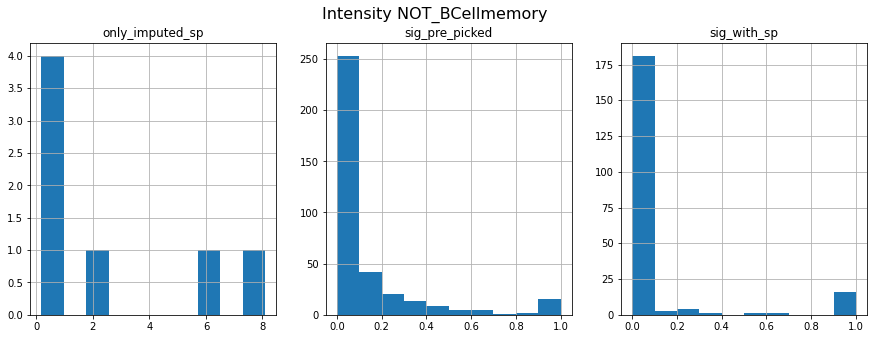

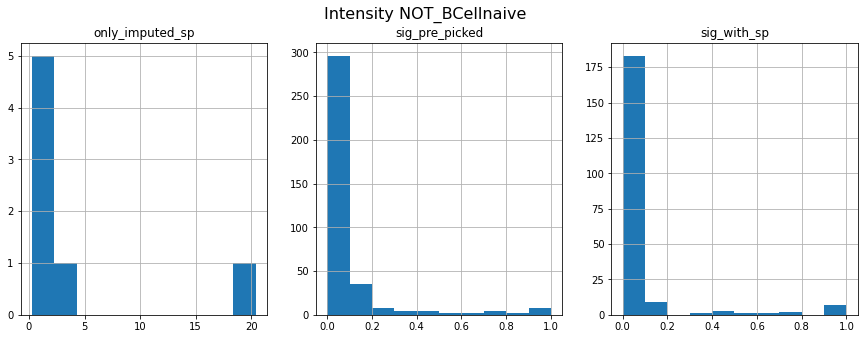

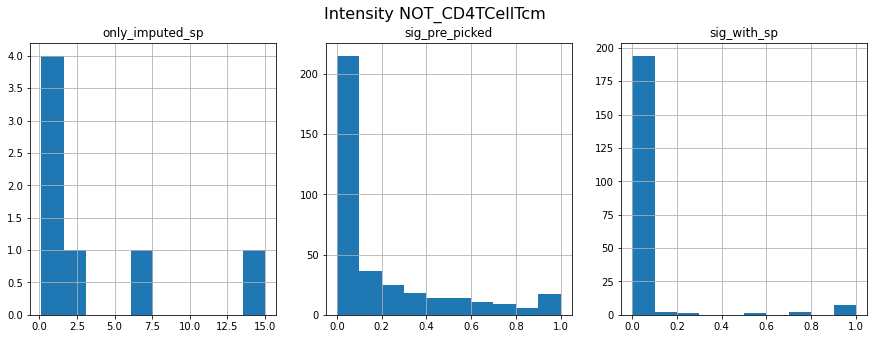

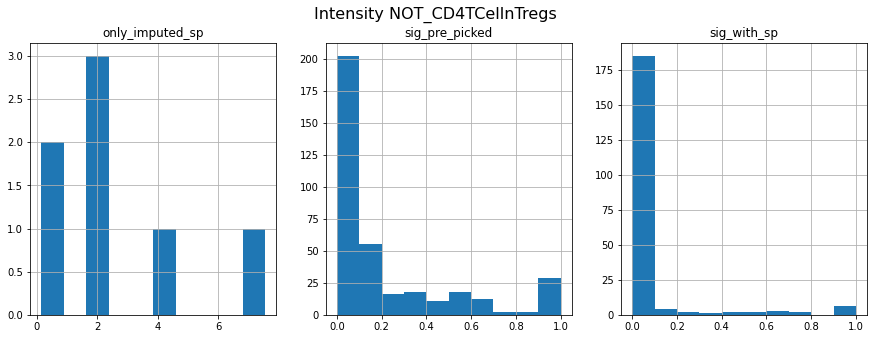

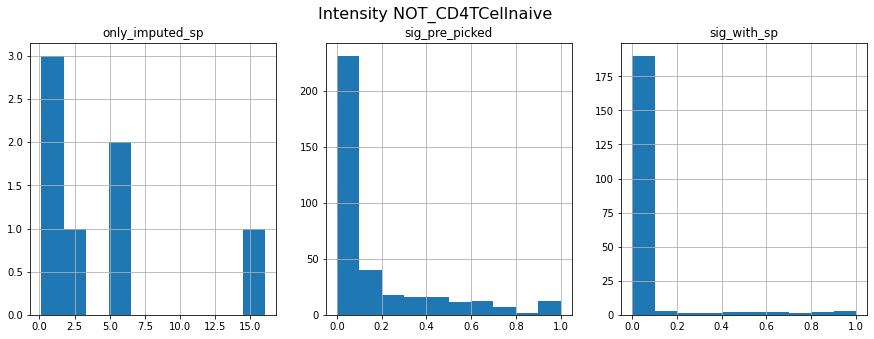

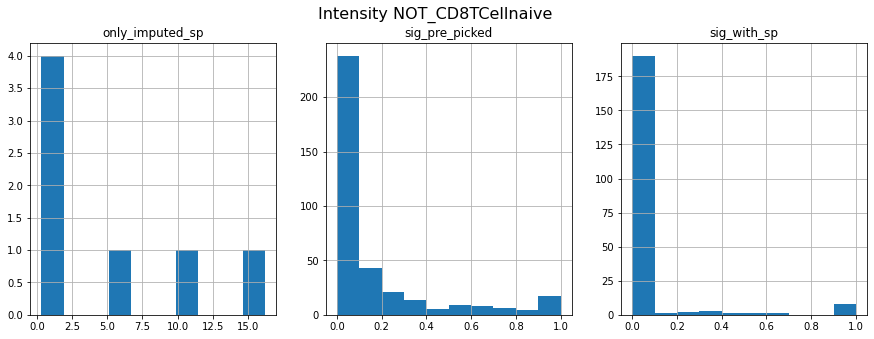

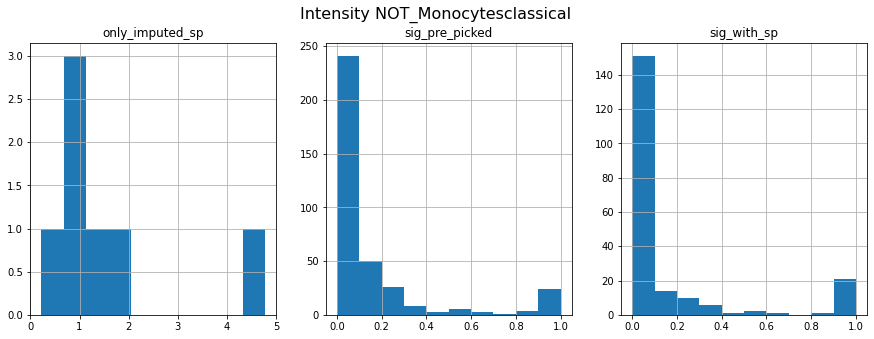

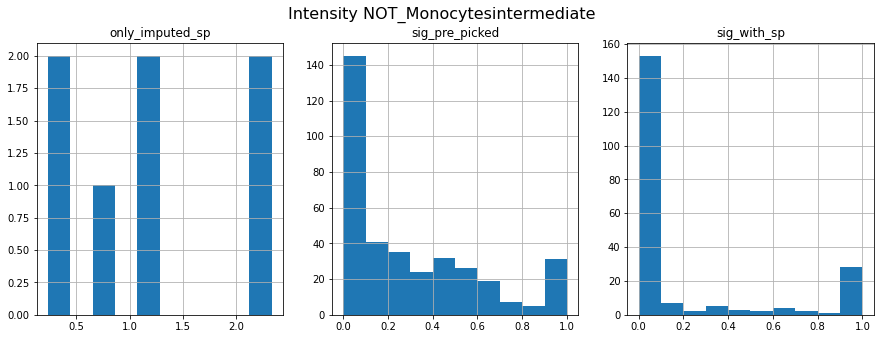

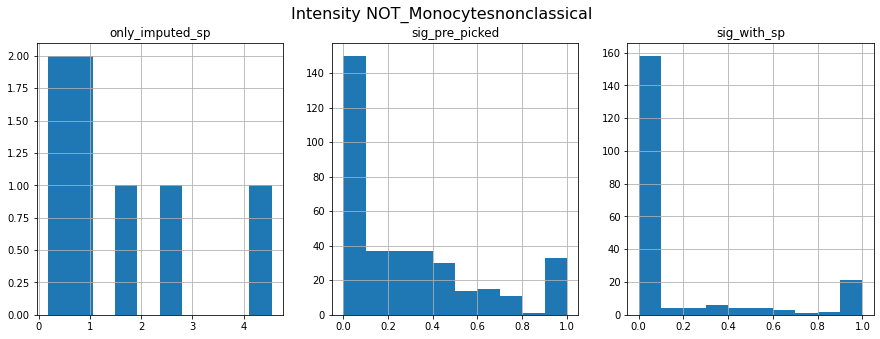

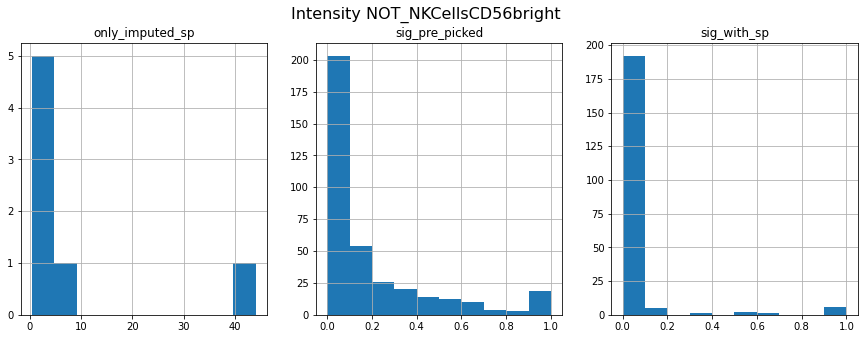

In [16]:
for cell in A_sig_pre_picked.columns :
    fig,axs = plt.subplots(1,3,figsize=(15,5))
    fig.suptitle(cell, fontsize=16)

    A_only_imputed_sp[cell].hist(ax=axs[0])
    axs[0].set_title("only_imputed_sp")
    A_sig_pre_picked[cell].hist(ax=axs[1])
    axs[1].set_title("sig_pre_picked")
    A_sig_with_sp[cell].hist(ax=axs[2])
    axs[2].set_title("sig_with_sp")

## compare

In [17]:
def weight_mixtures(A_sig,B_sig,sp_profile,sum_ratio = 0.01) : 
    gene_weights = _get_gene_weights(A_sig,sp_profile,sum_ratio = sum_ratio)
    return _update_mixtures_by_weight(B_sig,A_sig,gene_weights)

def run_experiment(A,B,sp_profile,is_with_with_em,is_basic) : 
    cell_abundance_over_samples = [] 
    for mixture in B : 
        if is_with_with_em :
            cell_abundance = em_deconvolution(B[mixture],A,sp_profile,basic=is_basic)
        else : 
            cell_abundance = _deconvolution(B[mixture],A,basic=is_basic)
            
        cell_abundance_df = pd.DataFrame(data=cell_abundance, index=A.columns, columns=[mixture])
        cell_abundance_over_samples.append(cell_abundance_df)
    deconv = pd.concat(cell_abundance_over_samples, axis=1)
    deconv = (deconv / deconv.sum(
                axis=0)).round(2)
    _print_results(deconv)


In [24]:
signatures_opts = [("only_imputed_sp",A_only_imputed_sp,B_only_imputed_sp),("sig_pre_picked",A_sig_pre_picked,B_sig_pre_picked),("sig_with_sp",A_sig_with_sp,B_sig_with_sp)]
is_basic_opts = [True,False]
with_EM_opts = [True,False]
with_weights_opts = [True,False]



signature :only_imputed_sp,nnls:True,with_em:True,with_weights:False
pearson 0.5385707559378351


B cells            0.078987
Monocytes          0.036573
NK                      NaN
Na?ve CD4 Tcell    0.281984
Na?ve CD8 Tcell         NaN
dtype: float64

spearman 0.4830651144029959


B cells            0.110810
Monocytes          0.079386
NK                      NaN
Na?ve CD4 Tcell    0.224983
Na?ve CD8 Tcell         NaN
dtype: float64

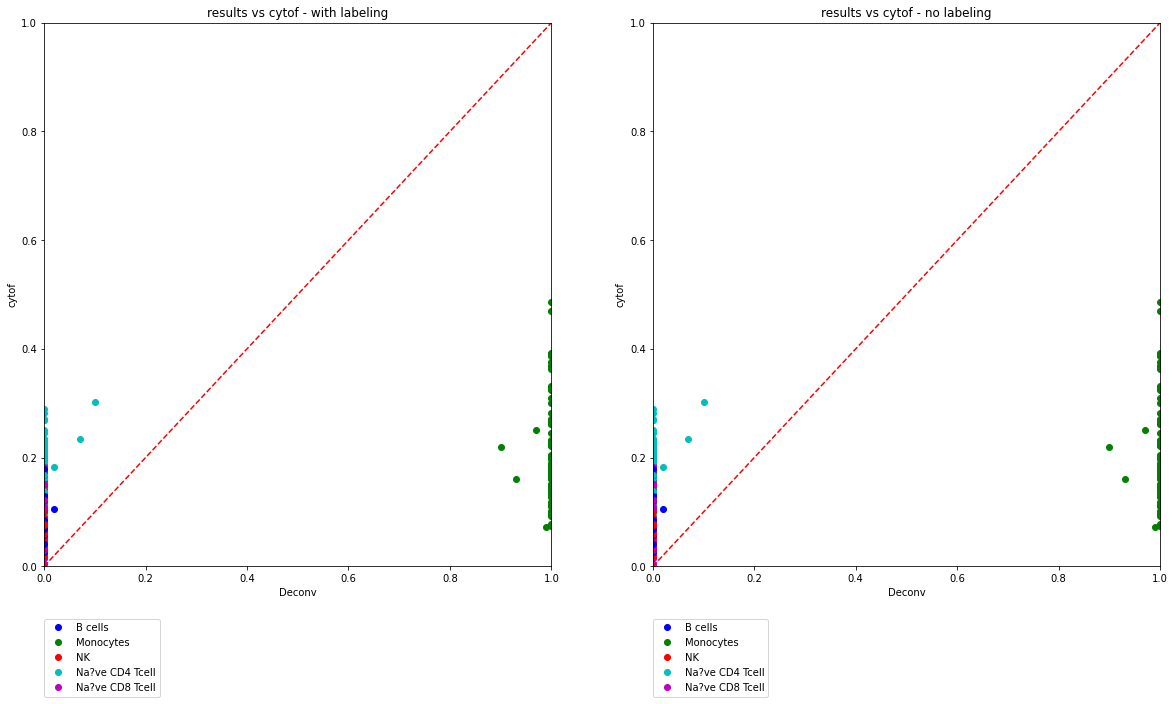

signature :only_imputed_sp,nnls:True,with_em:False,with_weights:False
pearson 0.5385707559378351


B cells            0.078987
Monocytes          0.036573
NK                      NaN
Na?ve CD4 Tcell    0.281984
Na?ve CD8 Tcell         NaN
dtype: float64

spearman 0.4830651144029959


B cells            0.110810
Monocytes          0.079386
NK                      NaN
Na?ve CD4 Tcell    0.224983
Na?ve CD8 Tcell         NaN
dtype: float64

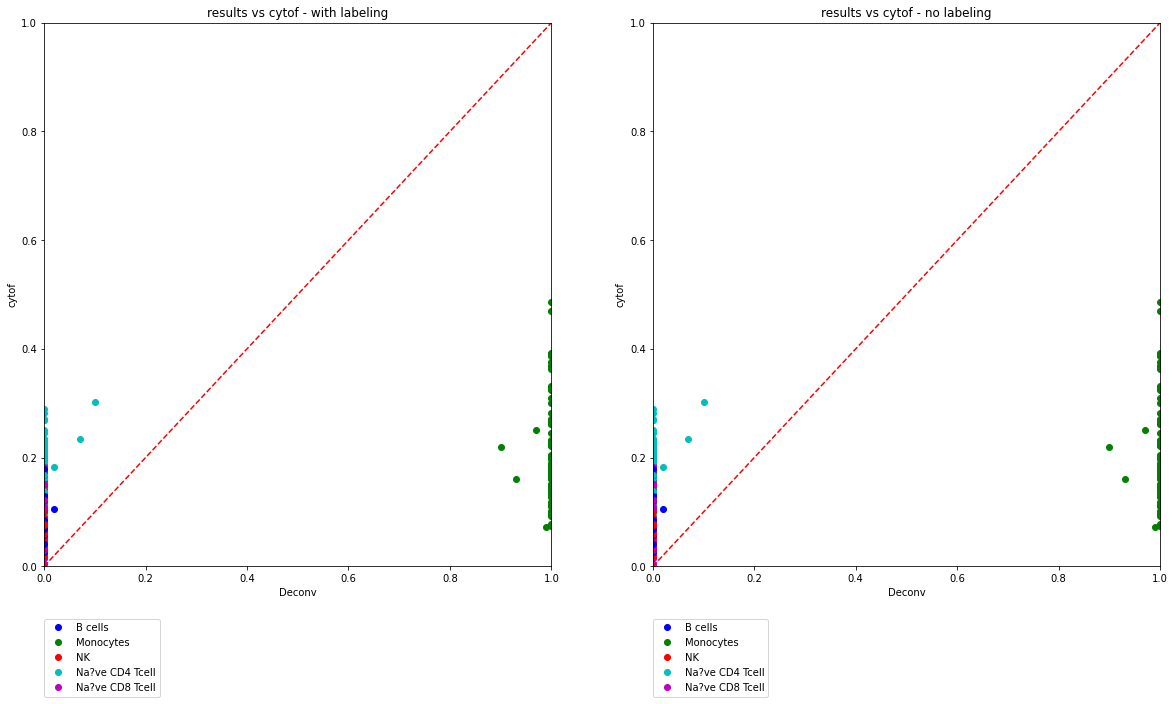

signature :sig_pre_picked,nnls:True,with_em:True,with_weights:False
pearson 0.4989022757156354


B cells            0.143313
Monocytes          0.115606
NK                      NaN
Na?ve CD4 Tcell         NaN
Na?ve CD8 Tcell         NaN
dtype: float64

spearman 0.31638944322080853


B cells            0.186595
Monocytes          0.099466
NK                      NaN
Na?ve CD4 Tcell         NaN
Na?ve CD8 Tcell         NaN
dtype: float64

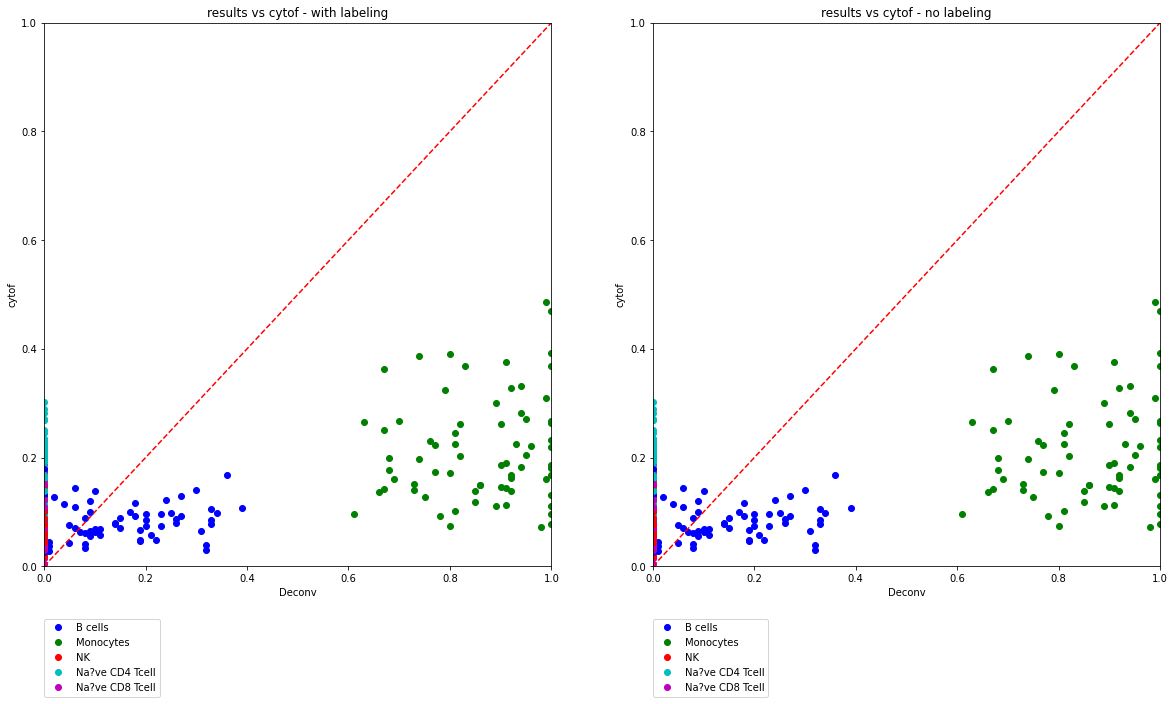

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


signature :sig_pre_picked,nnls:True,with_em:False,with_weights:True
pearson nan


B cells           NaN
Monocytes         NaN
NK                NaN
Na?ve CD4 Tcell   NaN
Na?ve CD8 Tcell   NaN
dtype: float64

spearman nan


B cells           NaN
Monocytes         NaN
NK                NaN
Na?ve CD4 Tcell   NaN
Na?ve CD8 Tcell   NaN
dtype: float64

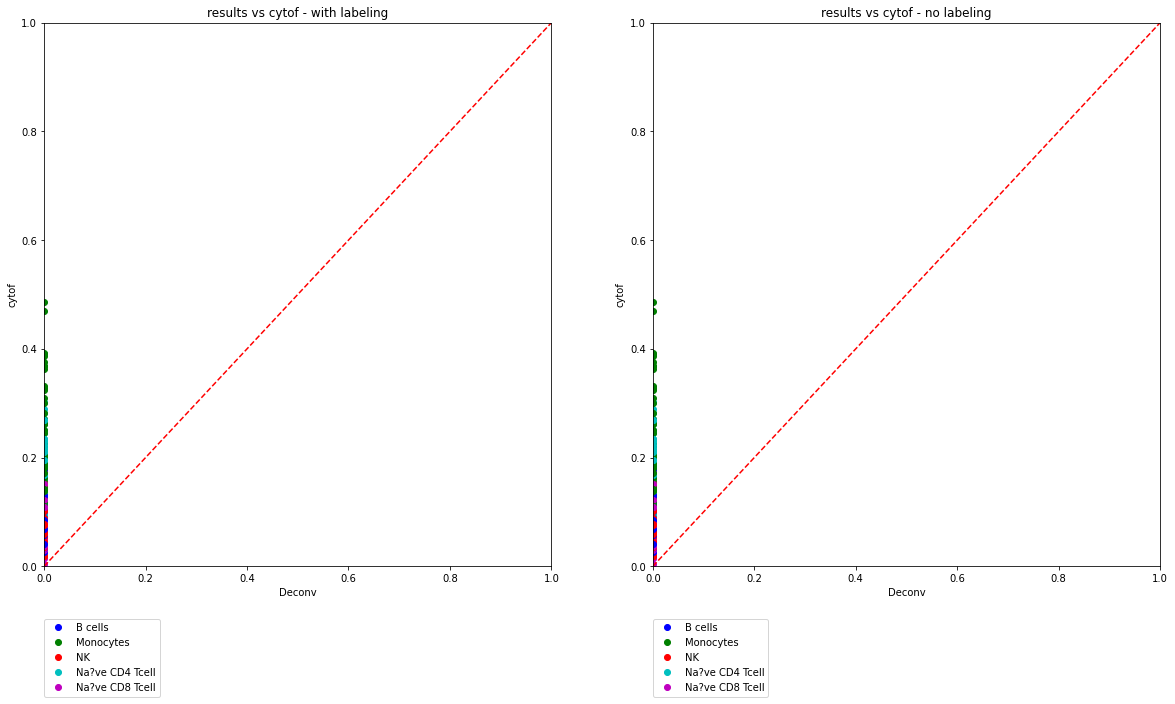

signature :sig_pre_picked,nnls:True,with_em:False,with_weights:False
pearson 0.4977699556426159


B cells            0.142860
Monocytes          0.116699
NK                      NaN
Na?ve CD4 Tcell         NaN
Na?ve CD8 Tcell         NaN
dtype: float64

spearman 0.31638944322080853


B cells            0.187660
Monocytes          0.093393
NK                      NaN
Na?ve CD4 Tcell         NaN
Na?ve CD8 Tcell         NaN
dtype: float64

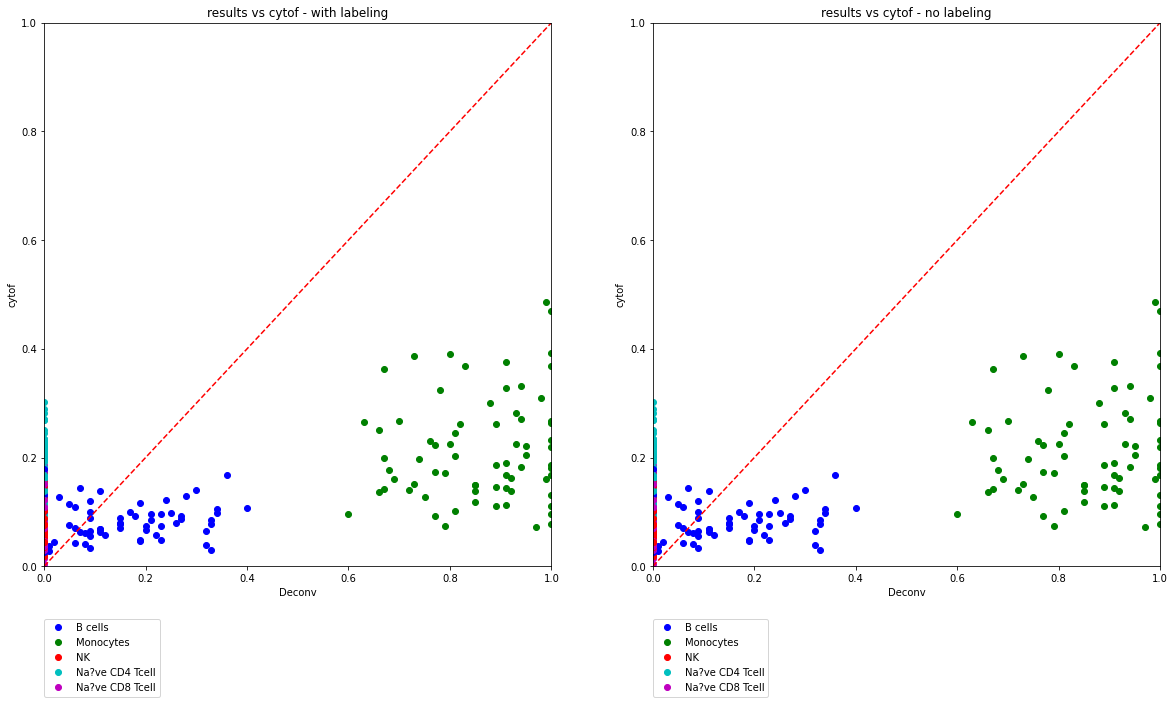

signature :sig_pre_picked,nnls:False,with_em:True,with_weights:True


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:165: RuntimeWarning: invalid value encountered in true_divide
  return self.M(tmp_resid / tmp_results.scale).sum()
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\norms.py:185: RuntimeWarning: invalid value encountered in less_equal
  return np.less_equal(np.abs(z), self.t)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weigh

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weigh

pearson nan


B cells           NaN
Monocytes         NaN
NK                NaN
Na?ve CD4 Tcell   NaN
Na?ve CD8 Tcell   NaN
dtype: float64

spearman nan


B cells           NaN
Monocytes         NaN
NK                NaN
Na?ve CD4 Tcell   NaN
Na?ve CD8 Tcell   NaN
dtype: float64

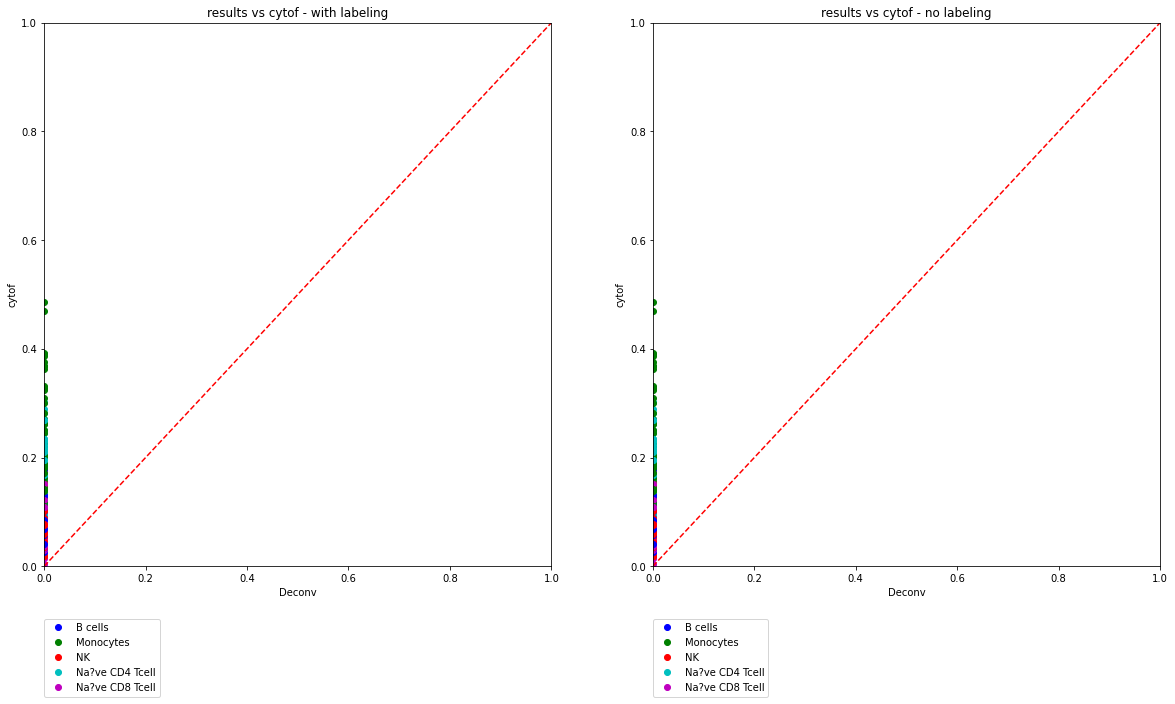

signature :sig_pre_picked,nnls:False,with_em:True,with_weights:False
pearson 0.4916069905210402


B cells            0.105798
Monocytes          0.375048
NK                -0.048556
Na?ve CD4 Tcell    0.062585
Na?ve CD8 Tcell    0.114945
dtype: float64

spearman 0.17506587919660468


B cells            0.205256
Monocytes          0.393129
NK                 0.029949
Na?ve CD4 Tcell    0.084426
Na?ve CD8 Tcell    0.016757
dtype: float64

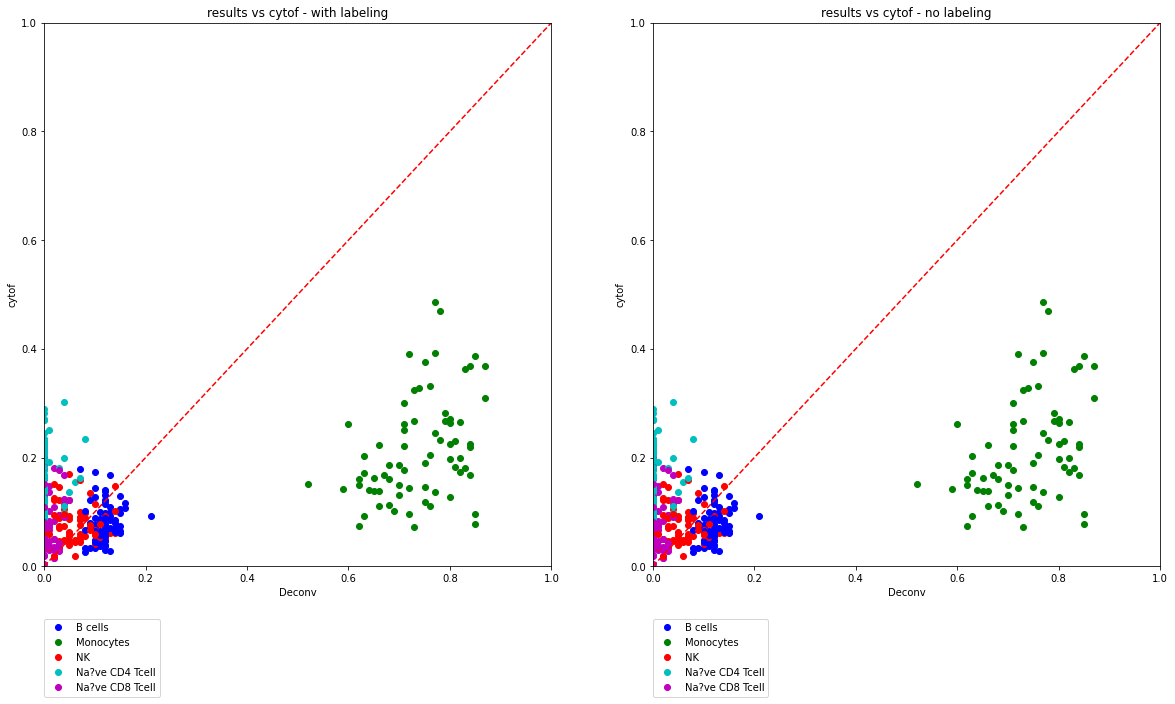

signature :sig_pre_picked,nnls:False,with_em:False,with_weights:True


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weigh

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weigh

pearson nan


B cells           NaN
Monocytes         NaN
NK                NaN
Na?ve CD4 Tcell   NaN
Na?ve CD8 Tcell   NaN
dtype: float64

spearman nan


B cells           NaN
Monocytes         NaN
NK                NaN
Na?ve CD4 Tcell   NaN
Na?ve CD8 Tcell   NaN
dtype: float64

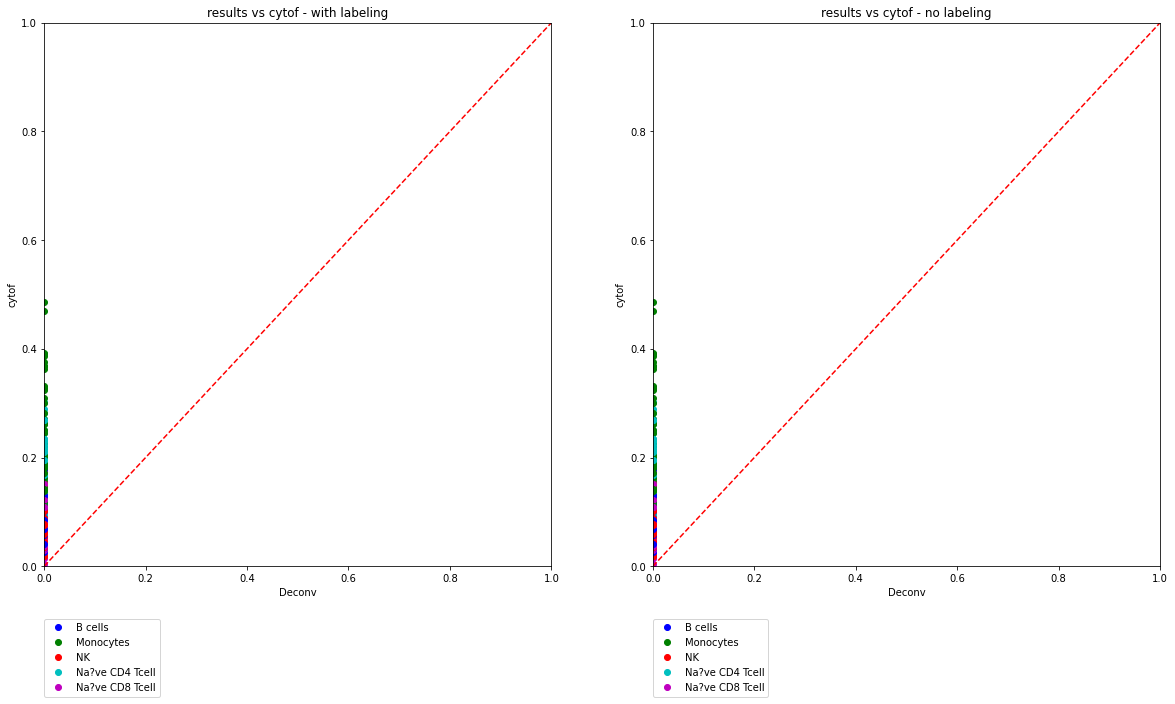

signature :sig_pre_picked,nnls:False,with_em:False,with_weights:False
pearson 0.4975366634065771


B cells            0.119516
Monocytes          0.412184
NK                -0.042246
Na?ve CD4 Tcell    0.061008
Na?ve CD8 Tcell    0.131325
dtype: float64

spearman 0.20415264282589657


B cells            0.201466
Monocytes          0.418409
NK                 0.030080
Na?ve CD4 Tcell    0.064207
Na?ve CD8 Tcell    0.005669
dtype: float64

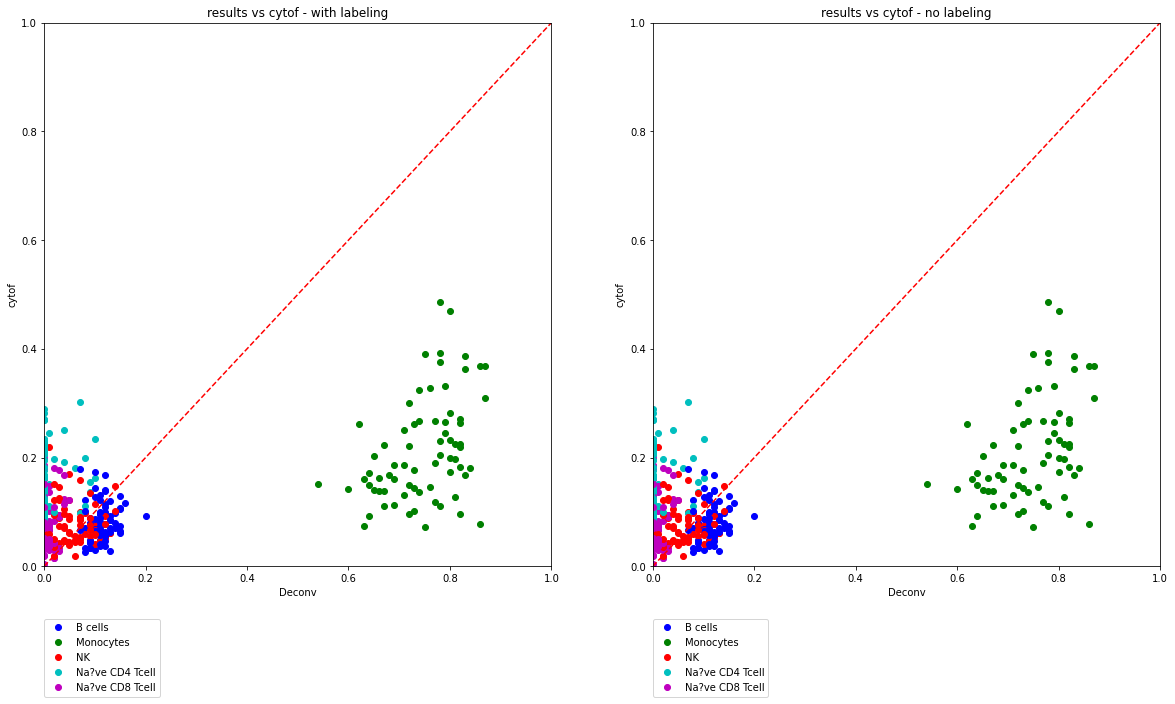

signature :sig_with_sp,nnls:True,with_em:True,with_weights:True
pearson nan


B cells           NaN
Monocytes         NaN
NK                NaN
Na?ve CD4 Tcell   NaN
Na?ve CD8 Tcell   NaN
dtype: float64

spearman nan


B cells           NaN
Monocytes         NaN
NK                NaN
Na?ve CD4 Tcell   NaN
Na?ve CD8 Tcell   NaN
dtype: float64

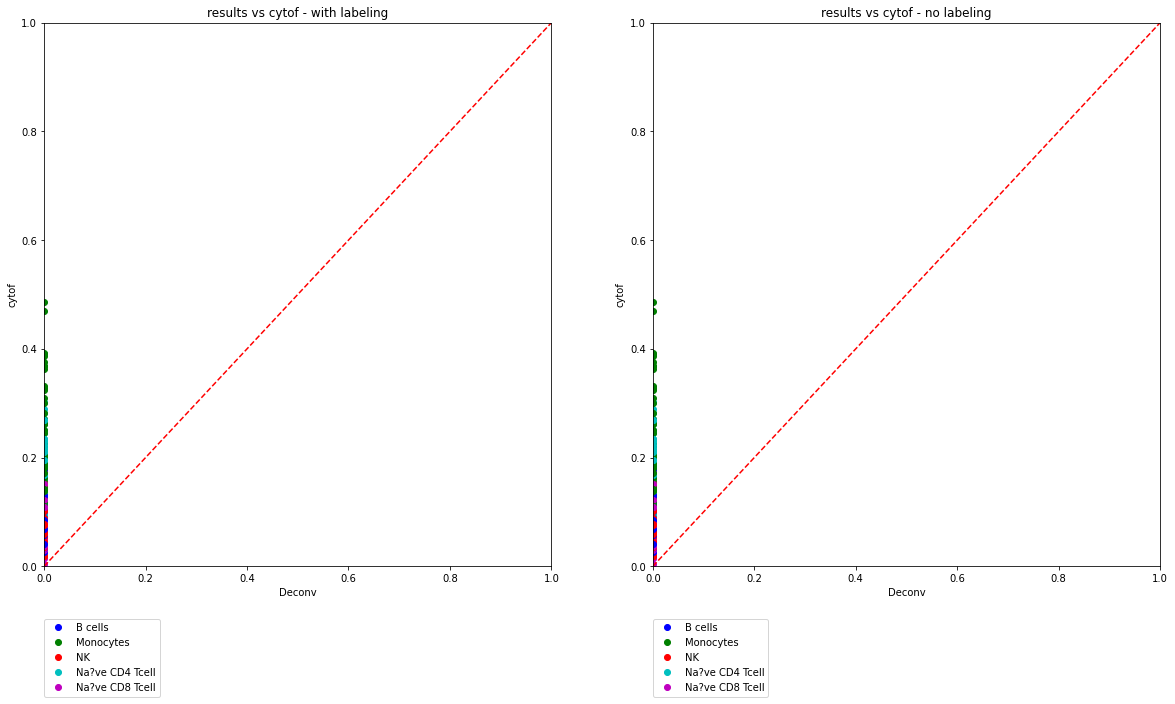

signature :sig_with_sp,nnls:True,with_em:True,with_weights:False
pearson 0.5576872798086677


B cells           -0.087810
Monocytes          0.007132
NK                 0.131488
Na?ve CD4 Tcell    0.246255
Na?ve CD8 Tcell    0.020161
dtype: float64

spearman 0.5846735545611788


B cells           -0.066748
Monocytes          0.123158
NK                 0.184497
Na?ve CD4 Tcell    0.244997
Na?ve CD8 Tcell    0.075818
dtype: float64

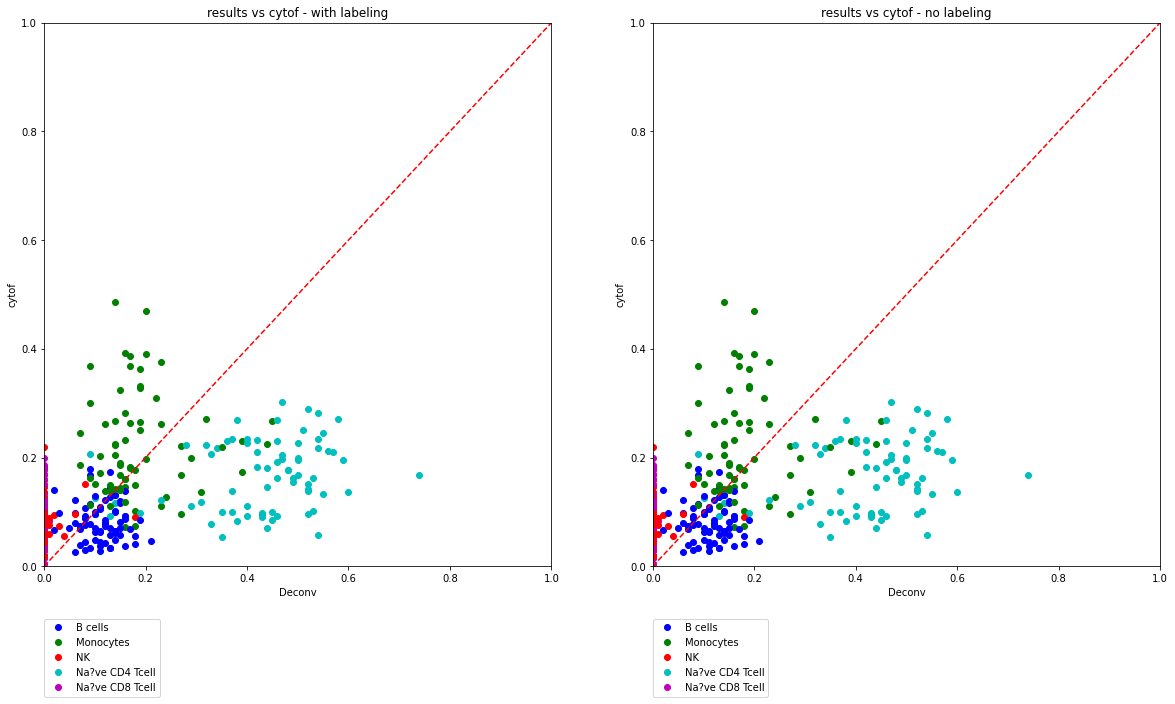

signature :sig_with_sp,nnls:True,with_em:False,with_weights:True
pearson nan


B cells           NaN
Monocytes         NaN
NK                NaN
Na?ve CD4 Tcell   NaN
Na?ve CD8 Tcell   NaN
dtype: float64

spearman nan


B cells           NaN
Monocytes         NaN
NK                NaN
Na?ve CD4 Tcell   NaN
Na?ve CD8 Tcell   NaN
dtype: float64

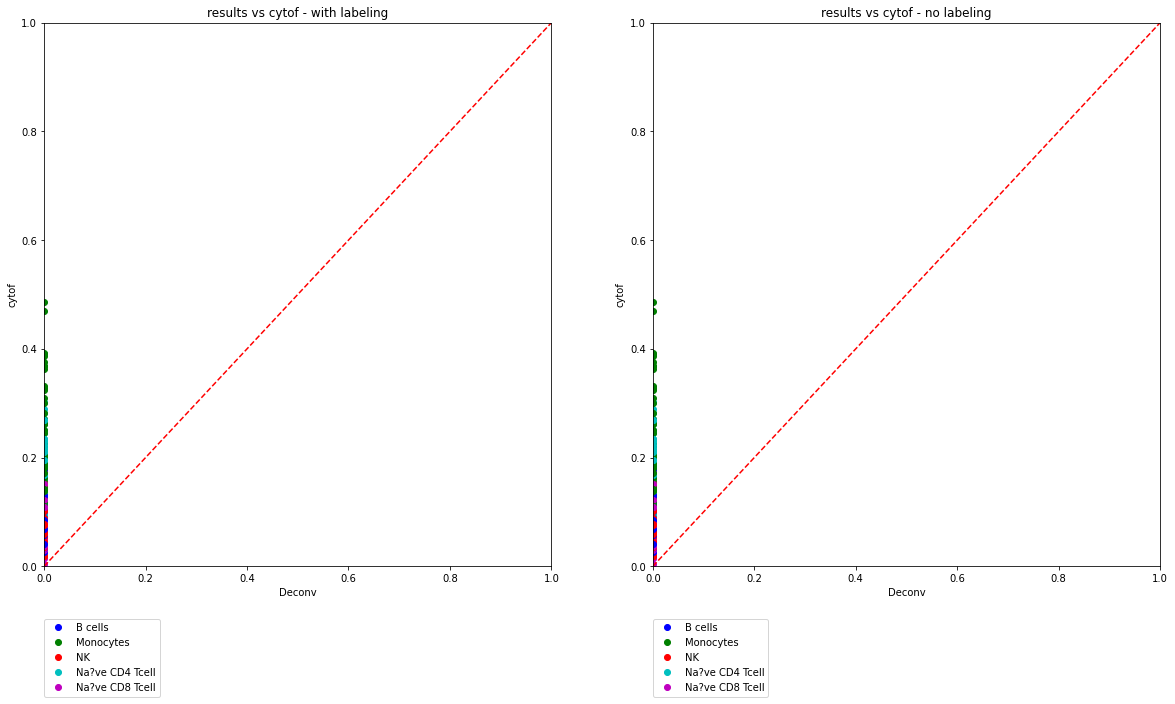

signature :sig_with_sp,nnls:True,with_em:False,with_weights:False
pearson 0.5539394861261563


B cells           -0.117813
Monocytes         -0.006470
NK                 0.039100
Na?ve CD4 Tcell    0.262955
Na?ve CD8 Tcell    0.020161
dtype: float64

spearman 0.5932787232735488


B cells           -0.105458
Monocytes          0.097891
NK                -0.009143
Na?ve CD4 Tcell    0.253531
Na?ve CD8 Tcell    0.075818
dtype: float64

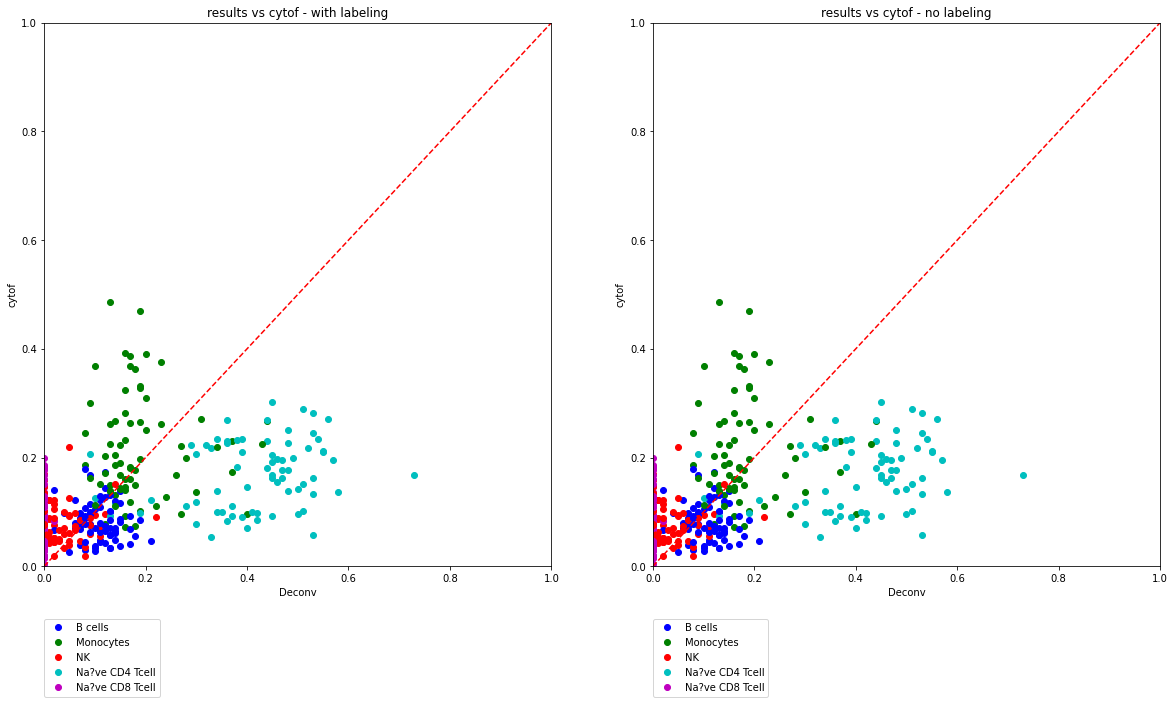

signature :sig_with_sp,nnls:False,with_em:True,with_weights:True


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weigh

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weigh

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weigh

pearson nan


B cells           NaN
Monocytes         NaN
NK                NaN
Na?ve CD4 Tcell   NaN
Na?ve CD8 Tcell   NaN
dtype: float64

spearman nan


B cells           NaN
Monocytes         NaN
NK                NaN
Na?ve CD4 Tcell   NaN
Na?ve CD8 Tcell   NaN
dtype: float64

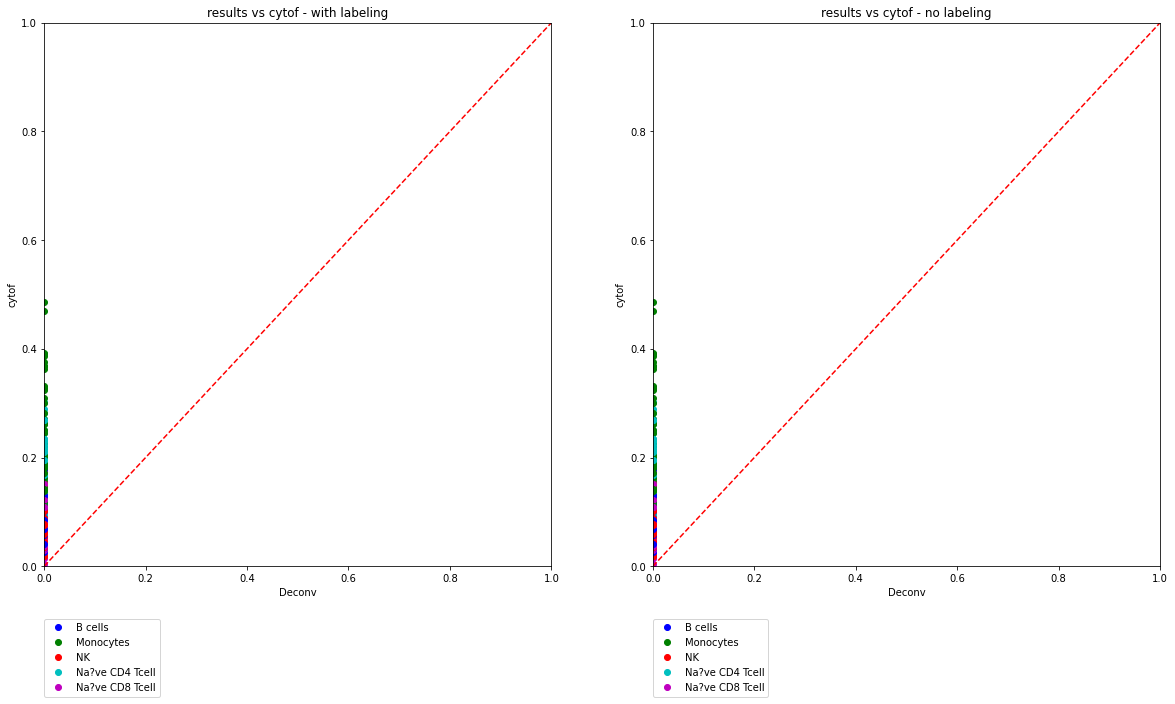

signature :sig_with_sp,nnls:False,with_em:True,with_weights:False
pearson 0.06148469951706897


B cells           -0.030226
Monocytes          0.412527
NK                -0.056387
Na?ve CD4 Tcell   -0.072135
Na?ve CD8 Tcell    0.166099
dtype: float64

spearman 0.09100972194983546


B cells           -0.044873
Monocytes          0.399474
NK                -0.037622
Na?ve CD4 Tcell   -0.075094
Na?ve CD8 Tcell    0.110120
dtype: float64

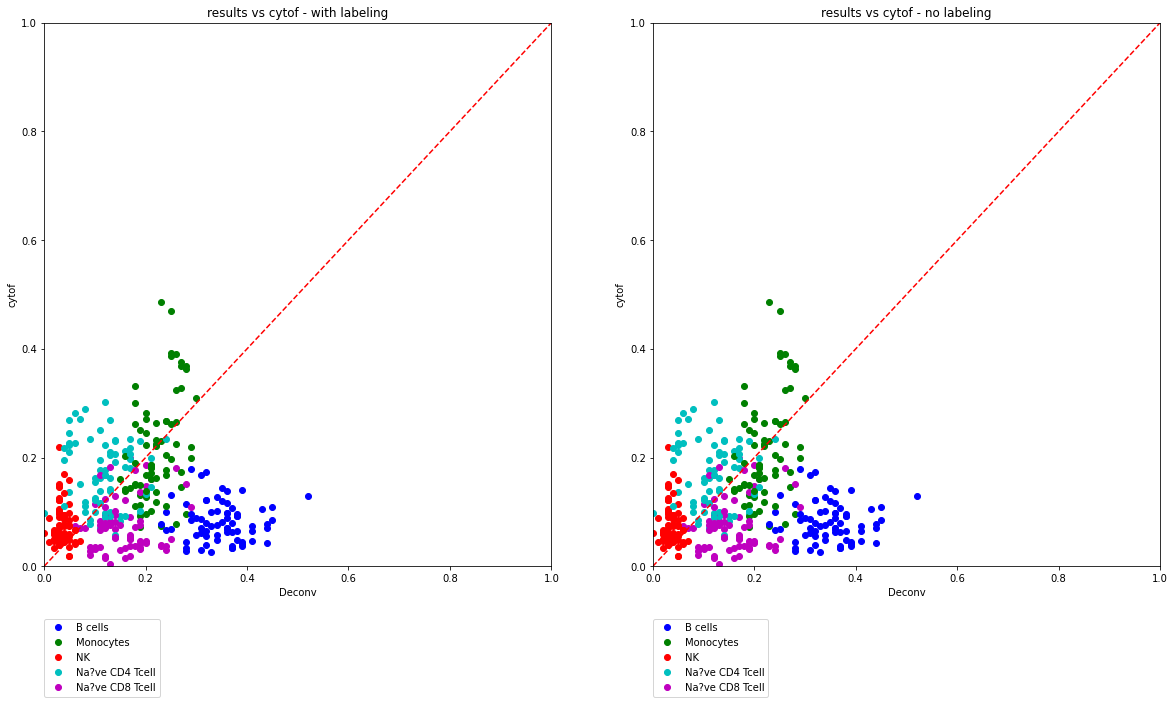

signature :sig_with_sp,nnls:False,with_em:False,with_weights:True


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weigh

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:289: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weigh

pearson nan


B cells           NaN
Monocytes         NaN
NK                NaN
Na?ve CD4 Tcell   NaN
Na?ve CD8 Tcell   NaN
dtype: float64

spearman nan


B cells           NaN
Monocytes         NaN
NK                NaN
Na?ve CD4 Tcell   NaN
Na?ve CD8 Tcell   NaN
dtype: float64

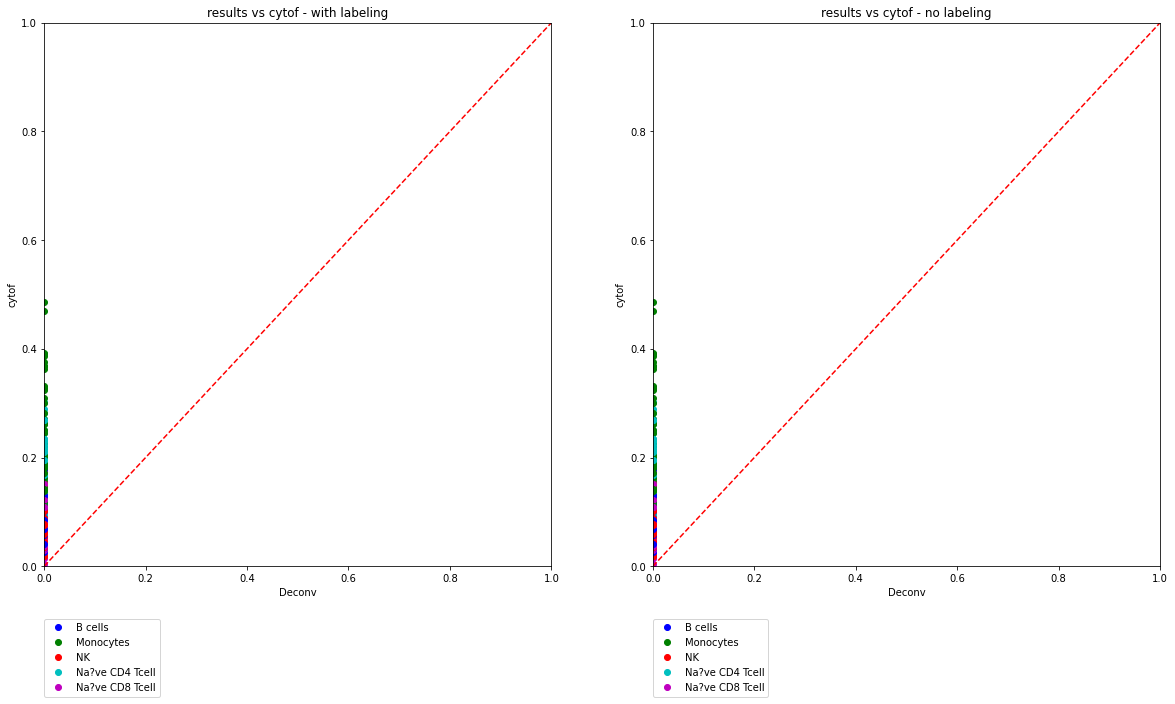

signature :sig_with_sp,nnls:False,with_em:False,with_weights:False
pearson 0.05712848581479259


B cells           -0.021199
Monocytes          0.419124
NK                -0.180259
Na?ve CD4 Tcell   -0.062244
Na?ve CD8 Tcell    0.165045
dtype: float64

spearman 0.08610295675630862


B cells           -0.012295
Monocytes          0.390336
NK                -0.147960
Na?ve CD4 Tcell   -0.059985
Na?ve CD8 Tcell    0.106622
dtype: float64

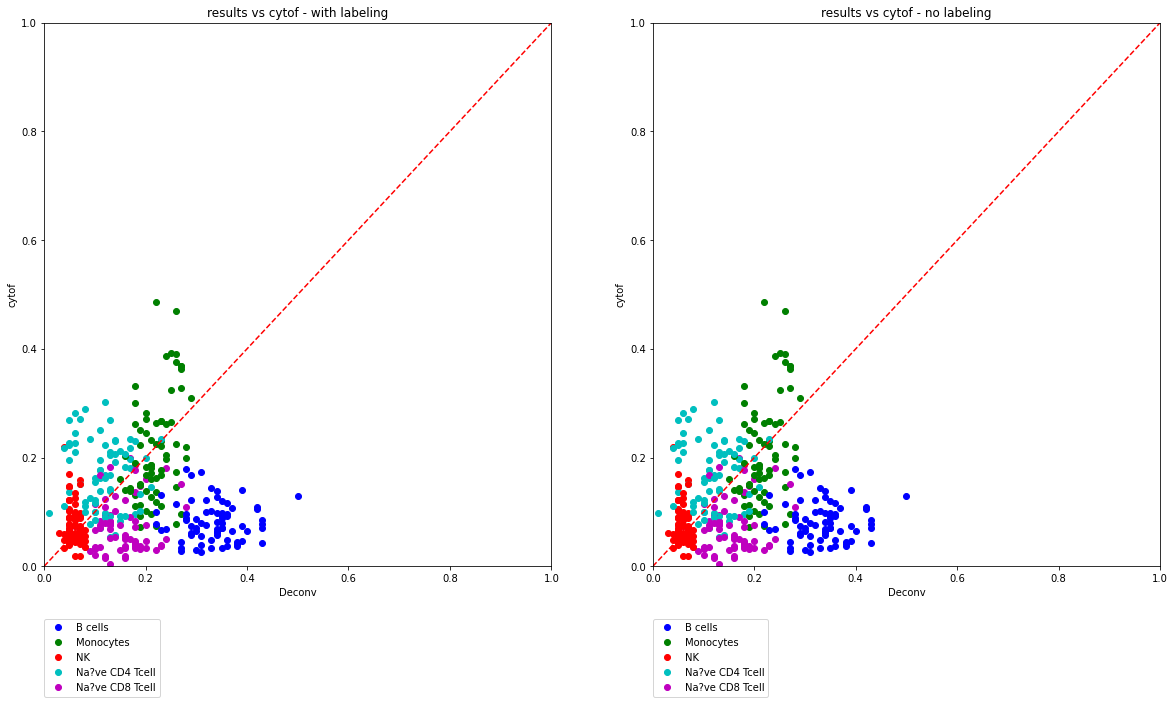

In [48]:
for sig,is_basic,with_EM,with_weights in itertools.product(signatures_opts,is_basic_opts,with_EM_opts,with_weights_opts) :
    if ((signature_type == "only_imputed_sp") and (with_weights or (not is_basic))):
        continue
    
    signature_type = sig[0]
    A_sig = sig[1]
    B_sig = sig[2]
    
    if with_weights : 
        B_sig,A_sig = weight_mixtures(A_sig,B_sig,sp_tith_multidx,sum_ratio = 0.01)
        
    print(f"signature :{signature_type},nnls:{is_basic},with_em:{with_EM},with_weights:{with_weights}")
    
    run_experiment(A_sig,B_sig,sp_tith_multidx,with_EM,is_basic)
    
        

# test

In [49]:
def build_distance_matrix() :
    uuid_to_results = {}
    for uuid in meta_results["uuid"] : 
        params = meta_results[meta_results["uuid"] == int(uuid)].T.copy(deep=True).dropna()
        
        best_results_and_known = _pipe.load_results_from_archive(uuid)
        best_results=best_results_and_known["result"]
        res_values = best_results.sort_index(axis=0).sort_index(axis=1).values
        
        uuid_to_results[uuid] = res_values
    
    results = {}
    looked_uuids = {}
    for uuid,res in uuid_to_results.items():
        if uuid in looked_uuids.keys():
            continue
            
        neighbors = [] 
        for sec_uuid,sec_res in uuid_to_results.items():
            if (res == sec_res).all() :
                neighbors.append(sec_uuid)
                looked_uuids[sec_uuid] = sec_uuid
        if len(neighbors) > 1 :
            results[uuid] = neighbors
    
    clusters = [] 
    for _,cluster in  results.items():
        uuids = [] 
        for uuid in cluster : 
            params = meta_results[meta_results["uuid"] == int(uuid)].T.copy(deep=True).dropna()
            uuids.append(params)
        clusters.append(pd.concat(uuids,axis=1))
        
    
    return clusters
      
def plot_correlation_per_cell(uuids) : 
    if type(uuids) is str : 
        uuids = [uuids]
    
    max_corr_per_cell = {}
    best_param_per_cell = {}
    
    for uuid in meta_results["uuid"] : 
        params = meta_results[meta_results["uuid"] == int(uuid)].T.copy(deep=True).dropna()
        
        best_results_and_known = _pipe.load_results_from_archive(uuid)
        best_results=best_results_and_known["result"]
        best_known=best_results_and_known["known"]
        mapping = GlobalUtils.get_corospanding_mixtures_map(best_known,best_results)
        best_known = best_known.rename(columns=mapping)
        best_known = best_known[[col for col in mapping.values()]]

        mutual_col = best_known.columns.intersection(best_results.columns)
        best_results = best_results[mutual_col]
        best_known = best_known[mutual_col]

        corr_per_cell =  best_results.T.corrwith(best_known.T,method="spearman")
        
        for cell in corr_per_cell.index : 
            if cell in max_corr_per_cell.keys() : 
                if corr_per_cell[cell] > max_corr_per_cell[cell] :
                    max_corr_per_cell[cell] = corr_per_cell[cell]
                    best_param_per_cell[cell] = params
            else : 
                max_corr_per_cell[cell] = corr_per_cell[cell]
                best_param_per_cell[cell] = params
    
    return max_corr_per_cell,best_param_per_cell

def plot_results_vs_known_pca(best_results,best_known):
    pca = PCA(n_components=2)
    pca.fit(pd.concat([best_results,best_known],axis=1).T)

    deconv_principalcomp = pca.transform(best_results.T)
    known_principalcomp = pca.transform(best_known.T)

    deconv_principalDf =pd.DataFrame(data = deconv_principalcomp
                 , columns = ['principal component 1', 'principal component 2'],index = best_results.columns)
    known_principalDf = pd.DataFrame(data = known_principalcomp
                 , columns = ['principal component 1', 'principal component 2'],index = best_known.columns)

    deconv_principalDf["color"] = "b"
    known_principalDf["color"] = "r"

    principalDf = deconv_principalDf.append(known_principalDf)
    fig = plt.figure(figsize = (25,15))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('blue - deconvolution result,red -  known proportions', fontsize = 20)

    ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'],c=principalDf['color'], s = 50)

    for mixture in range(deconv_principalcomp.shape[0]):
        deconv_point = deconv_principalcomp[mixture,:]
        known_point = known_principalcomp[mixture,:]
        plt.plot([deconv_point[0],known_point[0]],[deconv_point[1],known_point[1]], ':')

    for i, txt in enumerate(principalDf.index):
        ax.annotate(txt, (principalDf['principal component 1'].iloc[i], principalDf['principal component 2'].iloc[i]))

def describe_results(uuids,with_per_mixture_plot = False,with_mixtures_pca = False,meta_results = None) : 
    if type(uuids) is str : 
        uuids = [uuids]
    
    for uuid in uuids : 
        if meta_results is not None : 
            params = meta_results[meta_results["uuid"] == int(uuid)].T.copy(deep=True).dropna()
            print("params : ")
            display(HTML(params.to_html()))


        best_results_and_known = _pipe.load_results_from_archive(uuid)
        best_results=best_results_and_known["result"]
        best_known=best_results_and_known["known"]
        mapping = GlobalUtils.get_corospanding_mixtures_map(best_known,best_results)
        best_known = best_known.rename(columns=mapping)
        best_known = best_known[[col for col in mapping.values()]]

        mutual_col = best_known.columns.intersection(best_results.columns)
        best_results = best_results[mutual_col]
        best_known = best_known[mutual_col]

        print("mixtures : ")
        display(HTML(best_results.to_html()))

        print("mixtures details :")
        display(HTML(best_results.corrwith(best_known,method="spearman").describe().to_frame().to_html()))

        cytof_plots.plot_mass_to_cytof_scatter_all_on_one(best_results,best_known,best_results)
        if with_per_mixture_plot : 
            cytof_plots.plot_mass_to_cytof_scatter(best_results,best_known,best_results)
        if with_mixtures_pca : 
            plot_results_vs_known_pca(best_results,best_known)

In [6]:
_pipe = PipelineDeconv(hyper_configuration={},
                       hyper_measure_configuration={})
best_results_and_known = _pipe.load_results_from_archive("2532035938")
best_results=best_results_and_known["result"]
best_known=best_results_and_known["known"]

pearson 0.5273571258458057


B cells            0.390126
Monocytes          0.404823
NK                 0.067006
Na?ve CD4 Tcell    0.197592
Na?ve CD8 Tcell         NaN
dtype: float64

spearman 0.4620176848137263


B cells            0.351437
Monocytes          0.458458
NK                 0.053619
Na?ve CD4 Tcell    0.158715
Na?ve CD8 Tcell         NaN
dtype: float64

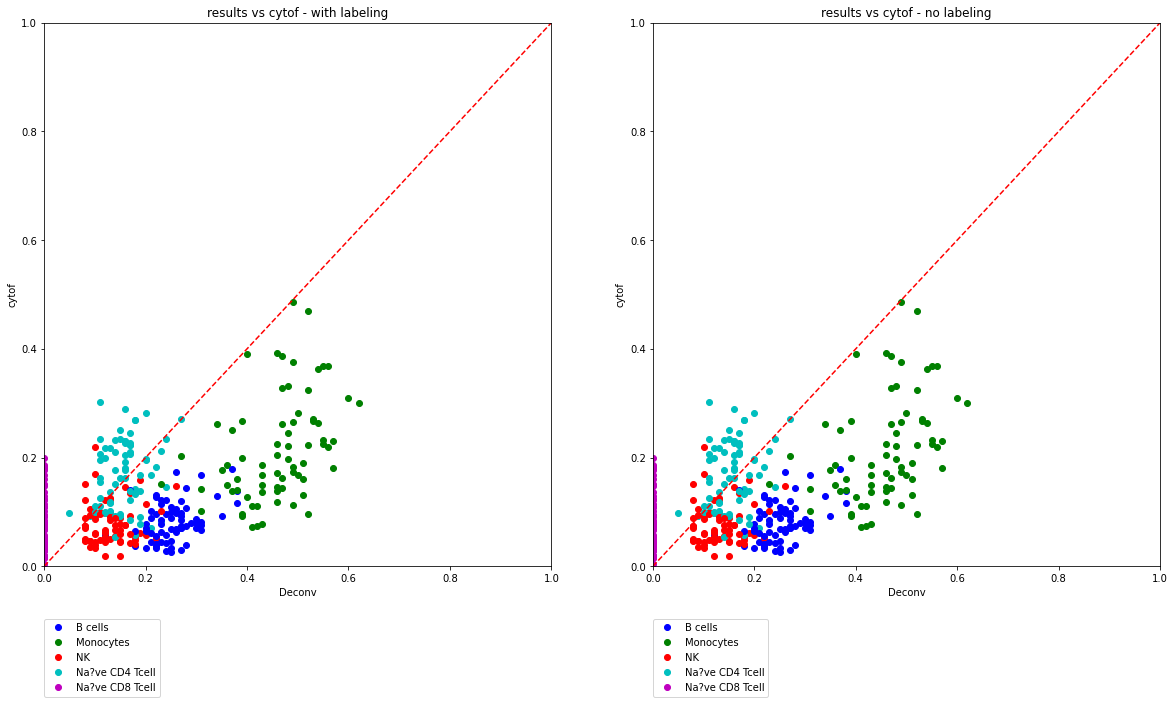

In [9]:
_print_results(best_results)

pearson 0.3677123056908963


B cells                         0.006934
CD4+ effector memory T cells    0.132377
CD8+ effector memory T cells    0.244577
Monocytes                       0.381606
NK                              0.148552
Na?ve CD4 Tcell                 0.326719
Na?ve CD8 Tcell                -0.023781
Plasmacytoid dendritic cells    0.258878
dtype: float64

spearman 0.4138772453531037


B cells                        -0.013275
CD4+ effector memory T cells    0.088637
CD8+ effector memory T cells    0.214397
Monocytes                       0.484647
NK                              0.191149
Na?ve CD4 Tcell                 0.365564
Na?ve CD8 Tcell                 0.007605
Plasmacytoid dendritic cells    0.233100
dtype: float64

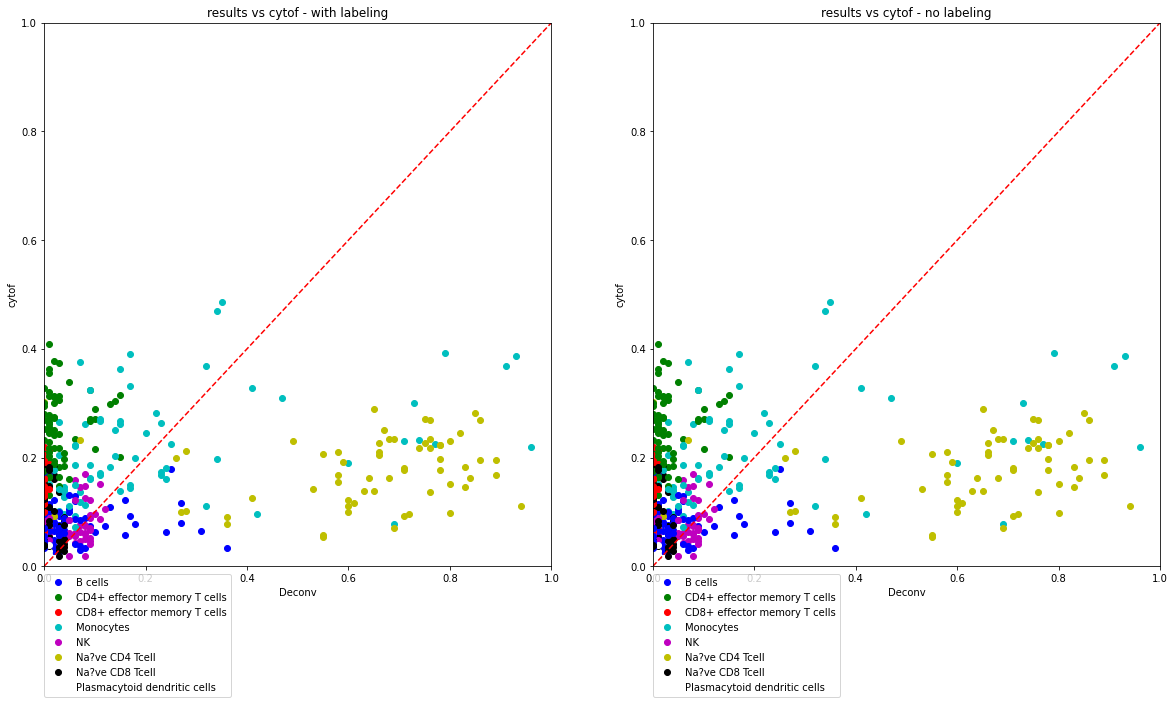

In [10]:
_pipe = PipelineDeconv(hyper_configuration={},
                       hyper_measure_configuration={})
best_results_and_known = _pipe.load_results_from_archive("2970852760")
best_results=best_results_and_known["result"]
best_known=best_results_and_known["known"]
_print_results(best_results)